<a href="https://colab.research.google.com/github/PercyMayaba/Driver-Risk-Scoring-Model/blob/main/DriverRisk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Cell 1: Install required packages (Fixed)
!pip install sdv scikit-plot xgboost tensorflow -q

In [ ]:
# Cell 2: Import necessary libraries (Fixed - removed problematic packages)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import joblib
import warnings
warnings.filterwarnings('ignore')

# Try to import scikit-plot with fallback
try:
    import scikitplot as skplt
    SKPLOT_AVAILABLE = True
    print("scikit-plot imported successfully!")
except ImportError:
    SKPLOT_AVAILABLE = False
    print("scikit-plot not available, using alternative plotting methods")

print("All essential libraries imported successfully!")

scikit-plot not available, using alternative plotting methods
All essential libraries imported successfully!


In [ ]:
# Cell 3: Generate synthetic telematics data
np.random.seed(42)

# Create synthetic dataset
n_samples = 10000
n_features = 8

X, y = make_classification(
    n_samples=n_samples,
    n_features=n_features,
    n_informative=6,
    n_redundant=2,
    n_clusters_per_class=1,
    n_classes=3,  # Low, Medium, High risk
    random_state=42
)

# Create meaningful feature names
feature_names = [
    'speed_variance',
    'harsh_braking_events',
    'hard_acceleration_count',
    'night_driving_frequency',
    'cornering_intensity',
    'mileage_per_trip',
    'rapid_lane_changes',
    'idle_time_ratio'
]

# Create DataFrame
df = pd.DataFrame(X, columns=feature_names)

# Scale features to meaningful ranges
df['speed_variance'] = np.abs(df['speed_variance'] * 15 + 20)  # 5-35 km/h variance
df['harsh_braking_events'] = np.abs(df['harsh_braking_events'] * 5 + 2)  # 0-10 events per week
df['hard_acceleration_count'] = np.abs(df['hard_acceleration_count'] * 8 + 3)  # 0-15 events per week
df['night_driving_frequency'] = (df['night_driving_frequency'] * 0.3 + 0.4).clip(0, 1)  # 0-100% of trips
df['cornering_intensity'] = np.abs(df['cornering_intensity'] * 2 + 1)  # 1-5 intensity scale
df['mileage_per_trip'] = np.abs(df['mileage_per_trip'] * 25 + 15)  # 0-50 km per trip
df['rapid_lane_changes'] = np.abs(df['rapid_lane_changes'] * 4 + 1)  # 0-8 events per week
df['idle_time_ratio'] = (df['idle_time_ratio'] * 0.2 + 0.1).clip(0, 0.3)  # 0-30% idle time

# Add target variable with meaningful labels
risk_mapping = {0: 'Low Risk', 1: 'Medium Risk', 2: 'High Risk'}
df['risk_level'] = [risk_mapping[val] for val in y]

print("Synthetic telematics data generated!")
print(f"Dataset shape: {df.shape}")
print("\nRisk level distribution:")
print(df['risk_level'].value_counts())

Synthetic telematics data generated!
Dataset shape: (10000, 9)

Risk level distribution:
risk_level
Medium Risk    3338
High Risk      3337
Low Risk       3325
Name: count, dtype: int64


In [ ]:
# Cell 4: Explore the dataset
print("=== Dataset Overview ===")
print(df.head())
print("\n=== Dataset Information ===")
print(df.info())
print("\n=== Statistical Summary ===")
print(df.describe())

=== Dataset Overview ===
   speed_variance  harsh_braking_events  hard_acceleration_count  \
0        1.449222              7.578050                 8.843140   
1       44.244940             18.240607                 7.708063   
2        1.196271              7.290738                 5.875014   
3       22.379180             16.453627                12.777083   
4       60.948838             38.663860                18.851213   

   night_driving_frequency  cornering_intensity  mileage_per_trip  \
0                 0.000000             2.214777         33.828001   
1                 0.765418             4.809074         36.359196   
2                 0.129568             2.406194         19.086832   
3                 0.000000             0.228365         45.295512   
4                 0.438078             4.098278        103.317421   

   rapid_lane_changes  idle_time_ratio   risk_level  
0            8.222227         0.141616    High Risk  
1            3.196621         0.000000  Med

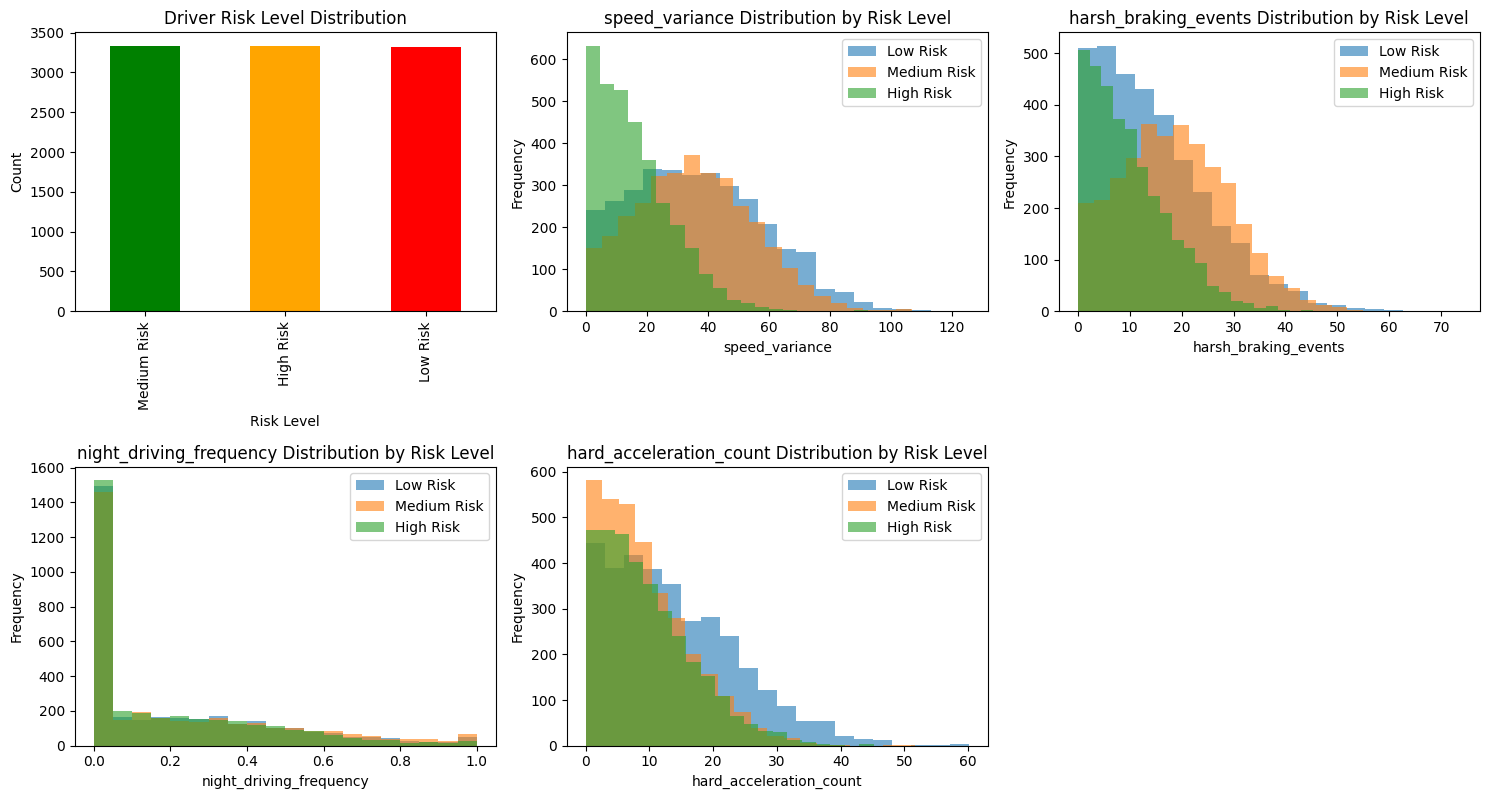

In [ ]:
# Cell 5: Visualize the data distribution
plt.figure(figsize=(15, 12))

# Risk level distribution
plt.subplot(3, 3, 1)
df['risk_level'].value_counts().plot(kind='bar', color=['green', 'orange', 'red'])
plt.title('Driver Risk Level Distribution')
plt.xlabel('Risk Level')
plt.ylabel('Count')

# Feature distributions by risk level
features_to_plot = ['speed_variance', 'harsh_braking_events', 'night_driving_frequency', 'hard_acceleration_count']

for i, feature in enumerate(features_to_plot, 2):
    plt.subplot(3, 3, i)
    for risk_level in ['Low Risk', 'Medium Risk', 'High Risk']:
        data = df[df['risk_level'] == risk_level][feature]
        plt.hist(data, alpha=0.6, label=risk_level, bins=20)
    plt.title(f'{feature} Distribution by Risk Level')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.legend()

plt.tight_layout()
plt.show()

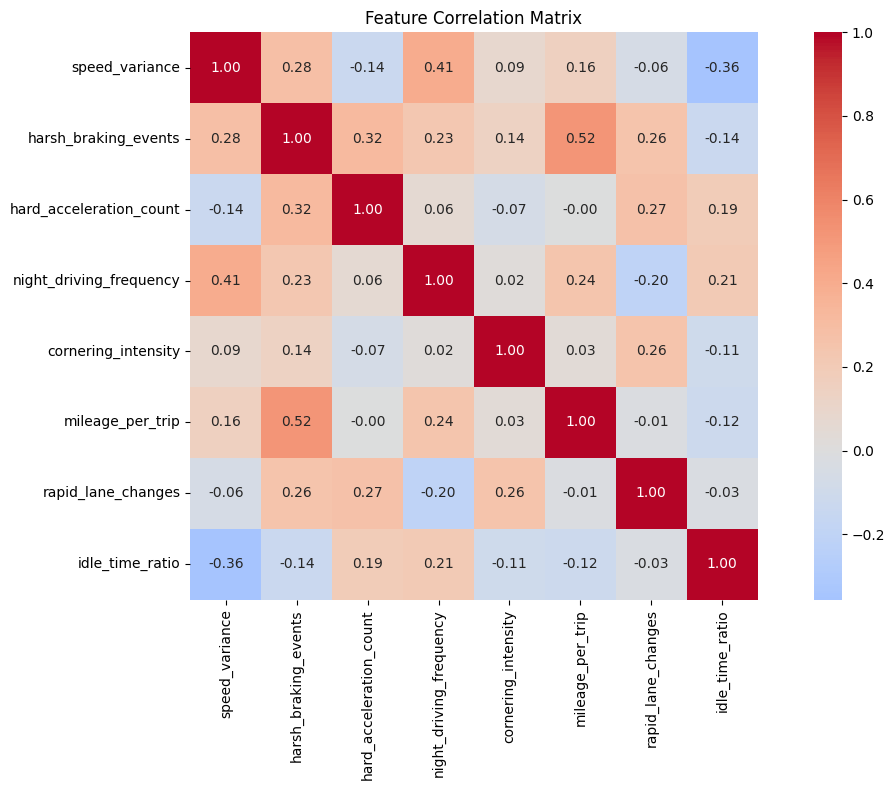

In [ ]:
# Cell 6: Correlation analysis
plt.figure(figsize=(12, 8))

# Select only numerical features for correlation
numerical_df = df.drop('risk_level', axis=1)

correlation_matrix = numerical_df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, fmt='.2f')
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

In [ ]:
# Cell 7: Prepare data for modeling
from sklearn.preprocessing import LabelEncoder

# Separate features and target
X = df.drop('risk_level', axis=1)
y = df['risk_level']

# Encode target variable
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Data preparation completed!")
print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")

# Store the label encoder for later use (e.g., inverse transform for predictions)
joblib.dump(le, 'label_encoder.pkl')
print("LabelEncoder saved to label_encoder.pkl")

Data preparation completed!
Training set: (8000, 8)
Test set: (2000, 8)
LabelEncoder saved to label_encoder.pkl


=== Random Forest Classifier ===
Accuracy: 0.9115

Classification Report:
              precision    recall  f1-score   support

   High Risk       0.91      0.90      0.90       667
    Low Risk       0.92      0.93      0.92       665
 Medium Risk       0.90      0.91      0.91       668

    accuracy                           0.91      2000
   macro avg       0.91      0.91      0.91      2000
weighted avg       0.91      0.91      0.91      2000



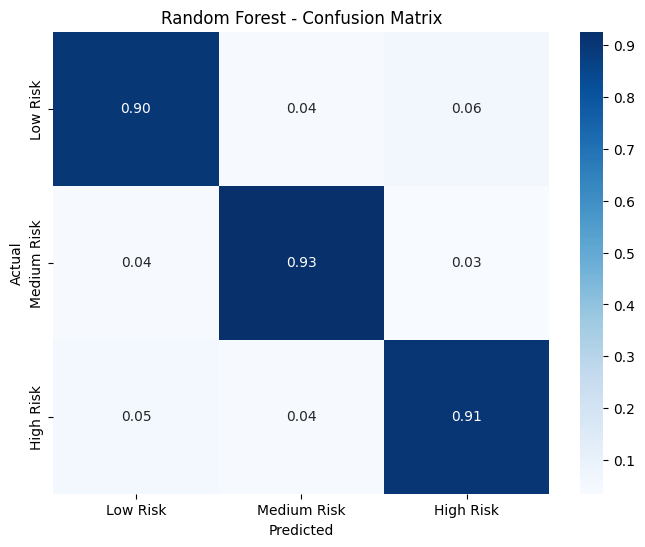

In [ ]:
# Cell 8: Random Forest Classifier (Updated with fallback)
print("=== Random Forest Classifier ===")

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predictions
y_pred_rf = rf_model.predict(X_test)

# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf))

# Confusion Matrix with fallback
plt.figure(figsize=(8, 6))
if SKPLOT_AVAILABLE:
    skplt.metrics.plot_confusion_matrix(y_test, y_pred_rf, normalize=True, cmap='Blues')
else:
    # Manual confusion matrix plot
    cm = confusion_matrix(y_test, y_pred_rf, normalize='true')
    sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=['Low Risk', 'Medium Risk', 'High Risk'],
                yticklabels=['Low Risk', 'Medium Risk', 'High Risk'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
plt.title('Random Forest - Confusion Matrix')
plt.show()

=== XGBoost Classifier ===
Accuracy: 0.9055

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.89      0.89       667
           1       0.92      0.92      0.92       665
           2       0.90      0.90      0.90       668

    accuracy                           0.91      2000
   macro avg       0.91      0.91      0.91      2000
weighted avg       0.91      0.91      0.91      2000



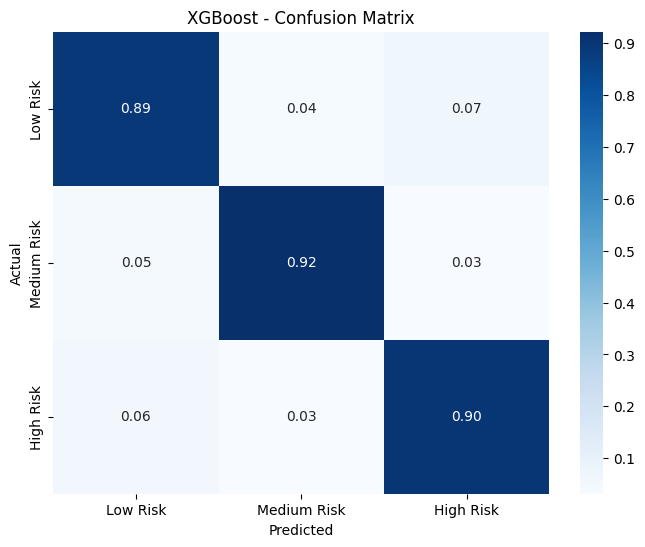

In [ ]:
# Cell 9: XGBoost Classifier (Updated with fallback)
print("=== XGBoost Classifier ===")

xgb_model = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    random_state=42,
    eval_metric='mlogloss'
)

xgb_model.fit(X_train, y_train)

# Predictions
y_pred_xgb = xgb_model.predict(X_test)

# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_xgb))

# Confusion Matrix with fallback
plt.figure(figsize=(8, 6))
if SKPLOT_AVAILABLE:
    skplt.metrics.plot_confusion_matrix(y_test, y_pred_xgb, normalize=True, cmap='Blues')
else:
    # Manual confusion matrix plot
    cm = confusion_matrix(y_test, y_pred_xgb, normalize='true')
    sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=['Low Risk', 'Medium Risk', 'High Risk'],
                yticklabels=['Low Risk', 'Medium Risk', 'High Risk'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
plt.title('XGBoost - Confusion Matrix')
plt.show()

=== Neural Network Classifier ===
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Accuracy: 0.9175

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.92      0.91       667
           1       0.93      0.93      0.93       665
           2       0.92      0.90      0.91       668

    accuracy                           0.92      2000
   macro avg       0.92      0.92      0.92      2000
weighted avg       0.92      0.92      0.92      2000



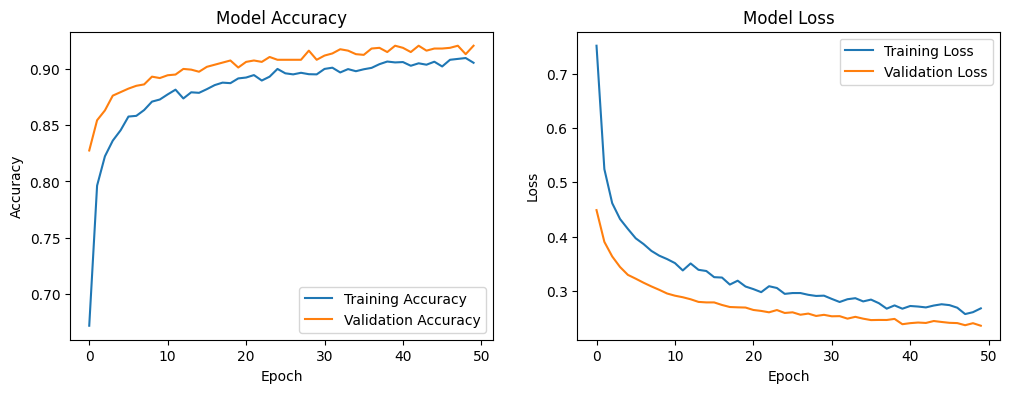

In [ ]:
# Cell 10: Neural Network Classifier
print("=== Neural Network Classifier ===")

# Convert labels to categorical
y_train_cat = pd.get_dummies(y_train)
y_test_cat = pd.get_dummies(y_test)

# Build neural network
nn_model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    layers.Dropout(0.3),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(16, activation='relu'),
    layers.Dense(3, activation='softmax')  # 3 output classes
])

# Compile the model
nn_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model
history = nn_model.fit(
    X_train_scaled, y_train_cat,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    verbose=0
)

# Predictions
y_pred_nn_proba = nn_model.predict(X_test_scaled)
y_pred_nn = np.argmax(y_pred_nn_proba, axis=1) # Modified to keep predictions as numerical labels

# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred_nn))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_nn))

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

=== Model Performance Comparison ===
            Model  Accuracy
0         XGBoost    0.9055
1  Neural Network    0.9175


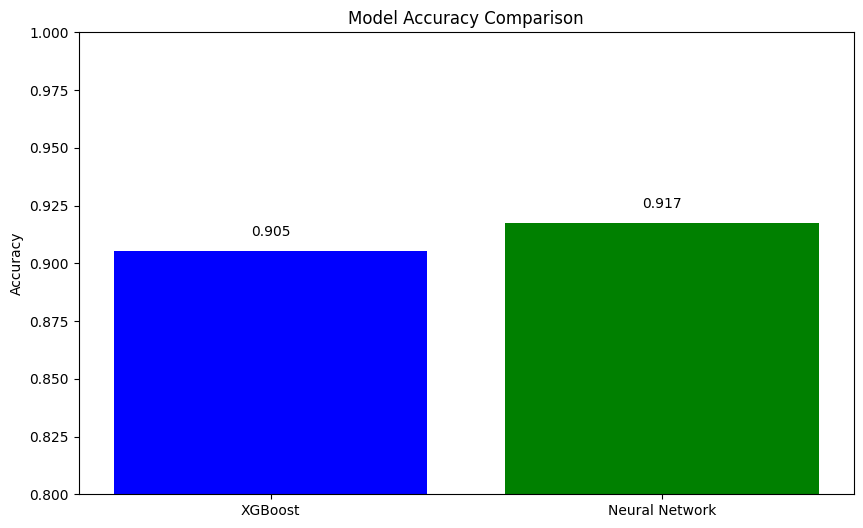

In [ ]:
# Cell 11: Model Comparison
print("=== Model Performance Comparison ===")

models = {

    'XGBoost': y_pred_xgb,
    'Neural Network': y_pred_nn
}

comparison_results = []
for name, predictions in models.items():
    accuracy = accuracy_score(y_test, predictions)
    comparison_results.append({'Model': name, 'Accuracy': accuracy})

comparison_df = pd.DataFrame(comparison_results)
print(comparison_df)

# Visual comparison
plt.figure(figsize=(10, 6))
plt.bar(comparison_df['Model'], comparison_df['Accuracy'], color=['blue', 'green', 'orange'])
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.ylim(0.8, 1.0)
for i, v in enumerate(comparison_df['Accuracy']):
    plt.text(i, v + 0.005, f'{v:.3f}', ha='center', va='bottom')
plt.show()

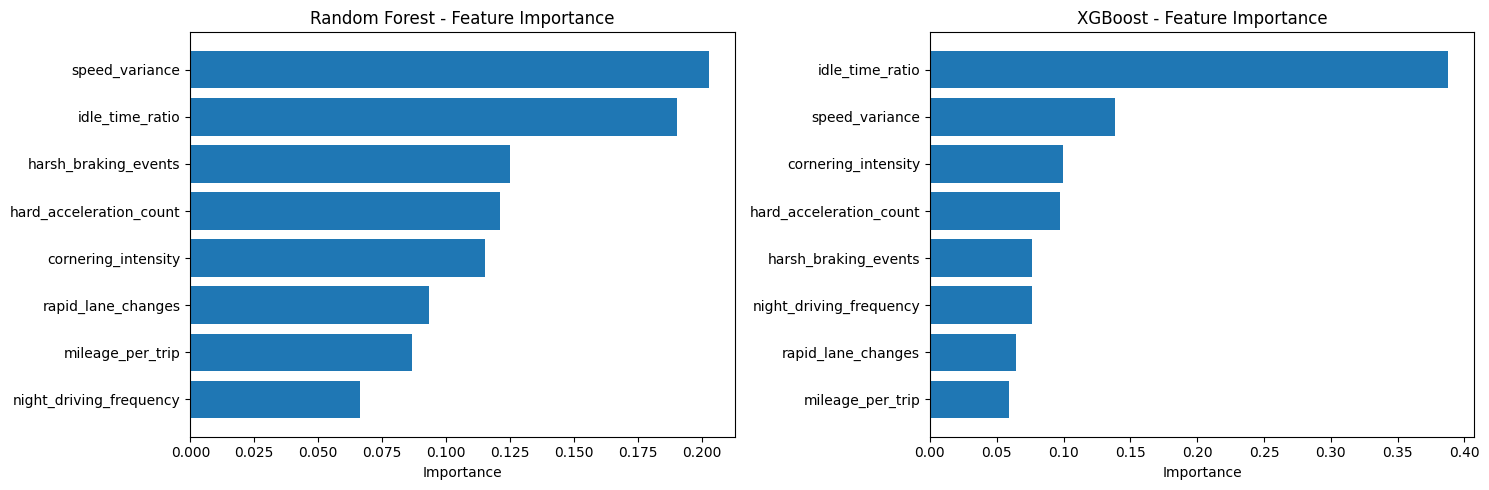

In [ ]:
# Cell 12: Feature Importance Analysis
plt.figure(figsize=(15, 5))

# Random Forest Feature Importance
plt.subplot(1, 2, 1)
feature_importance_rf = pd.DataFrame({
    'feature': feature_names,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=True)

plt.barh(feature_importance_rf['feature'], feature_importance_rf['importance'])
plt.title('Random Forest - Feature Importance')
plt.xlabel('Importance')

# XGBoost Feature Importance
plt.subplot(1, 2, 2)
feature_importance_xgb = pd.DataFrame({
    'feature': feature_names,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=True)

plt.barh(feature_importance_xgb['feature'], feature_importance_xgb['importance'])
plt.title('XGBoost - Feature Importance')
plt.xlabel('Importance')

plt.tight_layout()
plt.show()

In [ ]:
# Cell 13: Risk Scoring Application - Insurance Use Case
print("=== Insurance Risk Scoring Application ===")

# Create a function to predict risk and suggest premium multiplier
def calculate_risk_score_and_premium(driver_features, model, scaler=None):
    """
    Calculate risk score and suggest premium multiplier for insurance pricing
    """
    if scaler:
        driver_features_scaled = scaler.transform([driver_features])
        if hasattr(model, 'predict_proba'):
            risk_proba = model.predict_proba(driver_features_scaled)[0]
        else:
            risk_proba = model.predict(driver_features_scaled)[0]
    else:
        if hasattr(model, 'predict_proba'):
            risk_proba = model.predict_proba([driver_features])[0]
        else:
            risk_proba = model.predict([driver_features])[0]

    risk_levels = ['Low Risk', 'Medium Risk', 'High Risk']
    predicted_risk = risk_levels[np.argmax(risk_proba)]

    # Premium multipliers based on risk (insurance industry typical ranges)
    premium_multipliers = {
        'Low Risk': 0.8,      # 20% discount
        'Medium Risk': 1.0,   # Standard premium
        'High Risk': 1.5      # 50% surcharge
    }

    return {
        'predicted_risk': predicted_risk,
        'risk_probabilities': dict(zip(risk_levels, risk_proba)),
        'suggested_premium_multiplier': premium_multipliers[predicted_risk],
        'risk_score': np.argmax(risk_proba) + 1  # 1-3 scale
    }

# Test with sample drivers
sample_drivers = [
    [8.2, 1.5, 2.1, 0.2, 1.8, 12.3, 1.2, 0.08],   # Safe driver
    [25.6, 6.8, 9.2, 0.7, 3.9, 38.7, 5.8, 0.25],  # Risky driver
    [15.3, 3.2, 4.5, 0.4, 2.5, 22.1, 2.8, 0.15]   # Average driver
]

print("Sample Driver Risk Assessments:")
print("=" * 60)
for i, driver in enumerate(sample_drivers, 1):
    result = calculate_risk_score_and_premium(driver, xgb_model)
    print(f"Driver {i}:")
    print(f"  Predicted Risk: {result['predicted_risk']}")
    print(f"  Risk Score: {result['risk_score']}/3")
    print(f"  Premium Multiplier: {result['suggested_premium_multiplier']}x")
    print(f"  Risk Probabilities: {result['risk_probabilities']}")
    print("-" * 40)

=== Insurance Risk Scoring Application ===
Sample Driver Risk Assessments:
Driver 1:
  Predicted Risk: High Risk
  Risk Score: 3/3
  Premium Multiplier: 1.5x
  Risk Probabilities: {'Low Risk': np.float32(0.31894076), 'Medium Risk': np.float32(0.002344428), 'High Risk': np.float32(0.6787148)}
----------------------------------------
Driver 2:
  Predicted Risk: Low Risk
  Risk Score: 1/3
  Premium Multiplier: 0.8x
  Risk Probabilities: {'Low Risk': np.float32(0.9723813), 'Medium Risk': np.float32(0.01729974), 'High Risk': np.float32(0.010318922)}
----------------------------------------
Driver 3:
  Predicted Risk: Low Risk
  Risk Score: 1/3
  Premium Multiplier: 0.8x
  Risk Probabilities: {'Low Risk': np.float32(0.9474803), 'Medium Risk': np.float32(0.008034461), 'High Risk': np.float32(0.044485226)}
----------------------------------------


In [ ]:
# Cell 14: Business Impact Analysis
print("=== Business Impact Analysis ===")

# Simulate business impact
def analyze_business_impact(model, X_test, y_test, base_premium=1000):
    """
    Analyze the business impact of using the risk scoring model
    """
    predictions = model.predict(X_test)

    # Calculate premium adjustments
    premium_adjustments = []
    for pred in predictions:
        if pred == 'Low Risk':
            premium_adjustments.append(base_premium * 0.8)
        elif pred == 'Medium Risk':
            premium_adjustments.append(base_premium * 1.0)
        else:  # High Risk
            premium_adjustments.append(base_premium * 1.5)

    total_premium = sum(premium_adjustments)
    standard_premium = base_premium * len(predictions)

    return {
        'total_premium_risk_adjusted': total_premium,
        'total_premium_standard': standard_premium,
        'premium_difference': total_premium - standard_premium,
        'average_premium': np.mean(premium_adjustments),
        'risk_distribution': pd.Series(predictions).value_counts().to_dict()
    }

# Analyze impact with best model
impact = analyze_business_impact(xgb_model, X_test, y_test)

print("Business Impact Summary:")
print(f"Total Premium (Risk-Based): ${impact['total_premium_risk_adjusted']:,.2f}")
print(f"Total Premium (Standard): ${impact['total_premium_standard']:,.2f}")
print(f"Revenue Impact: ${impact['premium_difference']:,.2f}")
print(f"Average Premium per Driver: ${impact['average_premium']:,.2f}")
print(f"\nRisk Distribution in Test Set:")
for risk, count in impact['risk_distribution'].items():
    print(f"  {risk}: {count} drivers ({count/len(y_test)*100:.1f}%)")

=== Business Impact Analysis ===
Business Impact Summary:
Total Premium (Risk-Based): $3,000,000.00
Total Premium (Standard): $2,000,000.00
Revenue Impact: $1,000,000.00
Average Premium per Driver: $1,500.00

Risk Distribution in Test Set:
  2: 671 drivers (33.6%)
  0: 666 drivers (33.3%)
  1: 663 drivers (33.1%)


In [ ]:
# Cell 15: Export model and results
print("=== Exporting Model and Results ===")

# Save the best model (XGBoost in this case)
import joblib

# Save model and scaler
joblib.dump(xgb_model, 'driver_risk_model.pkl')
joblib.dump(scaler, 'scaler.pkl')

# Save feature names
with open('feature_names.txt', 'w') as f:
    for feature in feature_names:
        f.write(feature + '\n')

print("Model artifacts saved:")
print("driver_risk_model.pkl - Trained XGBoost model")
print("scaler.pkl - Feature scaler")
print("feature_names.txt - Feature names")

# Create summary report
summary = {
    'model_performance': {
        'accuracy': accuracy_score(y_test, y_pred_xgb),
        'best_model': 'XGBoost'
    },
    'dataset_info': {
        'total_samples': len(df),
        'features': len(feature_names),
        'risk_distribution': df['risk_level'].value_counts().to_dict()
    },
    'key_findings': {
        'most_important_features': feature_importance_xgb.nlargest(3, 'importance')['feature'].tolist(),
        'business_impact': f"${impact['premium_difference']:,.2f}"
    }
}

print("\nProject Summary:")
print(f"Best Model: {summary['model_performance']['best_model']} (Accuracy: {summary['model_performance']['accuracy']:.3f})")
print(f"Dataset: {summary['dataset_info']['total_samples']} drivers, {summary['dataset_info']['features']} features")
print(f"Top Features: {', '.join(summary['key_findings']['most_important_features'])}")
print(f"Business Impact: ${impact['premium_difference']:,.2f} revenue adjustment")

=== Exporting Model and Results ===
Model artifacts saved:
driver_risk_model.pkl - Trained XGBoost model
scaler.pkl - Feature scaler
feature_names.txt - Feature names

Project Summary:
Best Model: XGBoost (Accuracy: 0.905)
Dataset: 10000 drivers, 8 features
Top Features: idle_time_ratio, speed_variance, cornering_intensity
Business Impact: $1,000,000.00 revenue adjustment
